<a href="https://colab.research.google.com/github/zachfreitas/ADS_505_Applied_Data_Sci_for_Business-/blob/main/Module_3/Assignment_3/Zachariah_Freitas_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3.1
Zachariah Freitas <br>
2022-09-24

Import required packages

In [159]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [160]:
!pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [448]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pylab as plt

from dmba import plotDecisionTree, gainsChart, liftChart
from dmba import classificationSummary, regressionSummary
import dmba

%matplotlib inline

---
## Question 1
How can a predictive model based on these data be used by Yourcabs.com? (10
Points)


---
**Question 1 Answer:**
A predictive model, based on the data we have, can be used by Yourcabs.com to predict the probability of cancelation. We can use the probably of cancelation to only show ride requests to taxi drivers with the least probability of canceling. This way we reduce the overall cancel rate from 7.43% to something lower. We want to do this so that we don’t delay our customers or worse, leave them high and dry. We expect that decreasing cancellations will increase customer satisfaction which will lead to more revenue and increased profits.
---

---
## Question 2
How can a profiling model (identifying predictors that distinguish canceled/uncanceled trips) be used by Yourcabs.com? (10 Points)

---
**Question 2 Answer:**
We can use a profiling model to help us determine which variables are important for predicting canceled and non-canceled rides. We do this by using a model that has regularization built into it. Regularization will allow us to see what variables that model determines is important for predicting our outcome, in this instance ride cancellation. It will also show us which variables are not informative to the model. With this additional information, we may want to reevaluate the noninformative variables to see if they would benefit from any additional transformation before we totally rule them out.
---

---
## Question 3
Explore, prepare, and transform the data to facilitate predictive modeling. Here are some
hints: (15 Points)

## Data ETL and EDA

In [208]:
# Load the data
taxi_df_temp = pd.read_csv('https://raw.githubusercontent.com/zachfreitas/ADS_505_Applied_Data_Sci_for_Business-/main/Module_3/Assignment_3/Taxi-cancellation-case.csv')
taxi_df_temp.head()

,row#,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,1,17712,12,NaN,2,1021.0,1323.0,NaN,NaN,1/1/13 22:33,NaN,0,0,1/1/13 8:01,13.028530,77.54625,12.869805,77.653211,0
1,2,17037,12,NaN,2,455.0,1330.0,NaN,NaN,1/1/13 12:43,NaN,0,0,1/1/13 9:59,12.999874,77.67812,12.953434,77.706510,0
2,3,761,12,NaN,2,814.0,393.0,NaN,NaN,1/2/13 0:28,1/3/13 0:00,1,0,1/1/13 12:14,12.908993,77.68890,13.199560,77.706880,0
3,4,868,12,NaN,2,297.0,212.0,NaN,NaN,1/1/13 13:12,NaN,0,0,1/1/13 12:42,12.997890,77.61488,12.994740,77.607970,0
4,5,21716,28,NaN,2,1237.0,330.0,NaN,NaN,1/1/13 16:33,NaN,0,0,1/1/13 15:07,12.926450,77.61206,12.858833,77.589127,0


In [209]:
# Convert from/to lat/longs to a destination distance in kilometers.
import numpy as np

def haversine_vectorize(lon1, lat1, lon2, lat2):
  
  lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

  newlon = lon2 - lon1
  newlat = lat2 - lat1

  haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

  dist = 2 * np.arcsin(np.sqrt(haver_formula ))
  km = 6367 * dist #6367 for distance in KM for miles use 3958
  return km

taxi_df_temp['dist(km)'] = haversine_vectorize(taxi_df_temp['from_long'],
                                               taxi_df_temp['from_lat'],
                                               taxi_df_temp['to_long'],
                                               taxi_df_temp['to_lat'])

In [210]:
# # Adjust DTypes to category types
# def cat_types(df, columnName):
#   df[columnName] = df[columnName].astype("category")
#   return columnName

# # List to Apply Function to.
# cat_list = ['user_id', 'vehicle_model_id', 'package_id', 'travel_type_id']

# # List Comphension
# [cat_types(taxi_df, i) for i in cat_list]

In [211]:
# Look at missing values and column types
taxi_df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   row#                 10000 non-null  int64  
 1   user_id              10000 non-null  int64  
 2   vehicle_model_id     10000 non-null  int64  
 3   package_id           1752 non-null   float64
 4   travel_type_id       10000 non-null  int64  
 5   from_area_id         9985 non-null   float64
 6   to_area_id           7909 non-null   float64
 7   from_city_id         3706 non-null   float64
 8   to_city_id           339 non-null    float64
 9   from_date            10000 non-null  object 
 10  to_date              5822 non-null   object 
 11  online_booking       10000 non-null  int64  
 12  mobile_site_booking  10000 non-null  int64  
 13  booking_created      10000 non-null  object 
 14  from_lat             9985 non-null   float64
 15  from_long            9985 non-null   

In [212]:
# from sklearn.feature_selection import VarianceThreshold
# sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
# sel.fit_transform(taxi_df)

In [213]:
# Describe our data for numberic fields
taxi_df_temp.describe().T

,count,mean,std,min,25%,50%,75%,max
row#,10000.0,5000.500000,2886.895680,1.00000,2500.750000,5000.500000,7500.250000,10000.000000
user_id,10000.0,30663.966200,10988.599834,16.00000,24410.750000,31510.000000,39094.500000,48729.000000
vehicle_model_id,10000.0,26.191700,27.228053,1.00000,12.000000,12.000000,24.000000,91.000000
package_id,1752.0,1.988014,1.401791,1.00000,1.000000,2.000000,2.000000,7.000000
travel_type_id,10000.0,2.141300,0.434917,1.00000,2.000000,2.000000,2.000000,3.000000
from_area_id,9985.0,709.767752,418.968918,2.00000,393.000000,590.000000,1086.000000,1401.000000
to_area_id,7909.0,665.457833,400.628562,6.00000,393.000000,516.000000,1052.000000,1403.000000
from_city_id,3706.0,14.898003,1.190770,1.00000,15.000000,15.000000,15.000000,15.000000
to_city_id,339.0,68.318584,49.886427,4.00000,32.000000,49.000000,108.000000,203.000000
online_booking,10000.0,0.353300,0.478019,0.00000,0.000000,0.000000,1.000000,1.000000


In [214]:
# Convert string date columns to datetime columns.
def datetime_feature(df,columnName):
  # Get rid of infinite values
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  # Convert Object to Datetimestamp
  df[columnName] = pd.to_datetime(df[columnName], errors='coerce')
  # Fill Values
  df[columnName + '_' + 'year'] = df[columnName].dt.year.astype('Int64')
  df[columnName + '_' + 'month'] = df[columnName].dt.month.astype('Int64')
  df[columnName + '_' + 'day'] = df[columnName].dt.day.astype('Int64')
  df[columnName + '_' + 'hour'] = df[columnName].dt.hour.astype('Int64')
  df[columnName + '_' + 'minute'] = df[columnName].dt.minute.astype('Int64')
  return columnName
   

list = ['from_date',	'to_date', 'booking_created']

# List Comphension
[datetime_feature(taxi_df_temp, i) for i in list]

['from_date', 'to_date', 'booking_created']

In [215]:
# How far ahead are trips planned?
timedelta = taxi_df_temp['from_date']-taxi_df_temp['booking_created']
taxi_df_temp['time_delta(secs)'] = timedelta.astype('timedelta64[s]').astype(np.int32) # Minutes: 'timedelta64[m]' or / 60.0  Hours: 'timedelta64[h]' or / 3600.0
taxi_df_temp['time_delta(secs)'] 

0        52320
1         9840
2        44040
3         1800
4         5160
         ...  
9995     47040
9996    188340
9997    114180
9998    445440
9999      3540
Name: time_delta(secs), Length: 10000, dtype: int32

Remove Missing Values

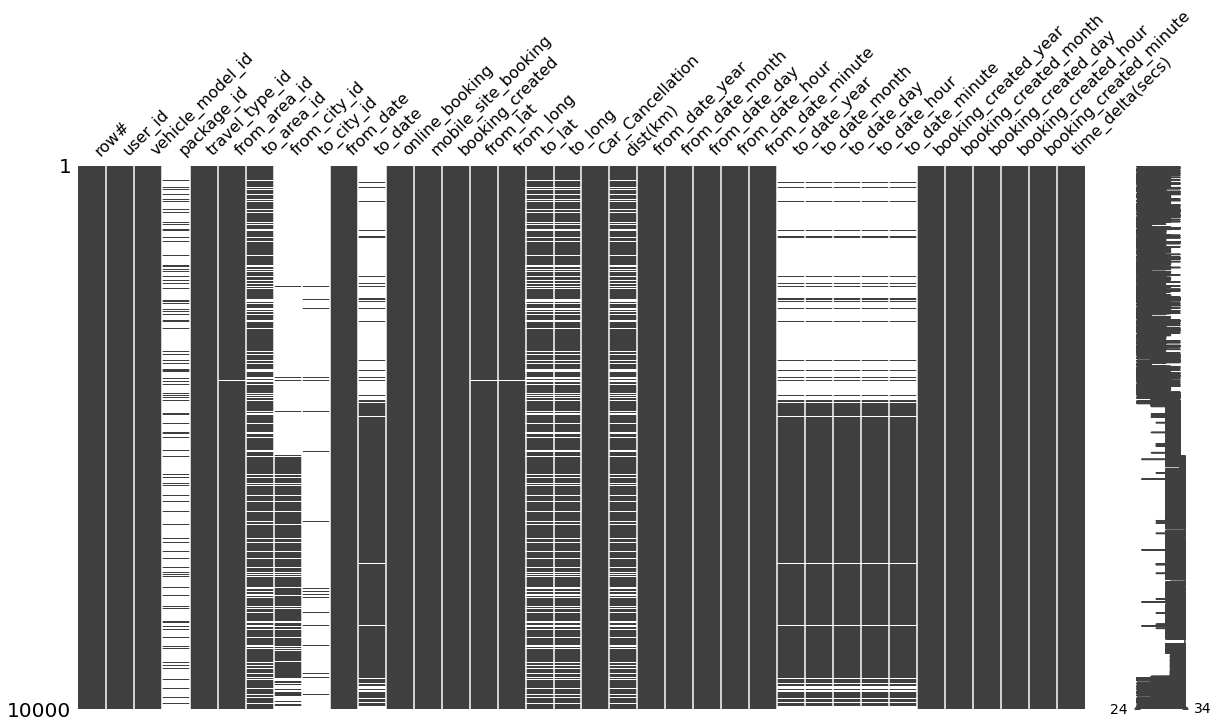

In [216]:
# Review Missing Values
import missingno as mno
mno.matrix(taxi_df_temp, figsize = (20, 10))


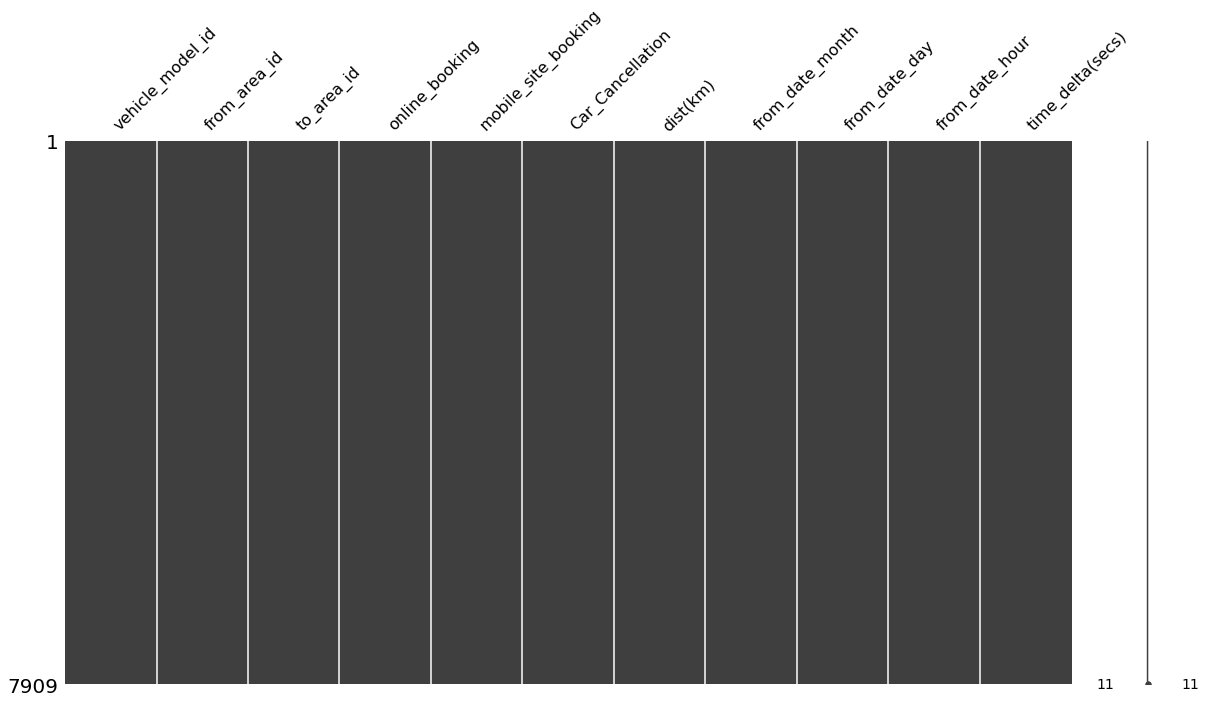

In [410]:
# Let's review where we drop columns that are missing more than 40% of the data.
# Then we drop rows with missing values.

drop_col = ['row#', # Ride id shouldn't be predictive of anything.
            'package_id','from_city_id', 'to_city_id','to_date', # Lots of missing values.
            'to_date_year', 'to_date_month','to_date_day', 'to_date_hour', 'to_date_minute', # Lots of missing values.
            'from_date', 'booking_created', #These were recoded to integers to be more useful
            'from_long','from_lat','to_long','to_lat', #These columns are not intuitively useful.
            'travel_type_id','from_date_year','booking_created_year', # These columns had zero variance
            'booking_created_month', 'booking_created_day', # Highly Correlated to From Dates
            'booking_created_hour', 'booking_created_minute', # Highly Correlated to From Dates
            'from_date_minute', # Low correlation to car cancellation
            'user_id' # High cardinality
            ]



mno.matrix(taxi_df_temp.drop(drop_col, axis=1).dropna(), figsize = (20, 10))           

In [411]:
# Save droped columns and rows
taxi_df = taxi_df_temp.drop(drop_col, axis=1).dropna().reset_index(drop=True)



In [412]:
taxi_df.describe().T

,count,mean,std,min,25%,50%,75%,max
vehicle_model_id,7909.0,25.196991,26.729222,1.0,12.000000,12.00000,23.000000,9.100000e+01
from_area_id,7909.0,707.383108,418.722582,2.0,393.000000,585.00000,1085.000000,1.401000e+03
to_area_id,7909.0,665.457833,400.628562,6.0,393.000000,516.00000,1052.000000,1.403000e+03
online_booking,7909.0,0.363763,0.481112,0.0,0.000000,0.00000,1.000000,1.000000e+00
mobile_site_booking,7909.0,0.046656,0.210914,0.0,0.000000,0.00000,0.000000,1.000000e+00
Car_Cancellation,7909.0,0.081679,0.273893,0.0,0.000000,0.00000,0.000000,1.000000e+00
dist(km),7909.0,17.244884,10.476732,0.0,8.382049,14.55602,26.258772,5.326001e+01
from_date_month,7909.0,6.446201,2.960248,1.0,4.000000,7.00000,9.000000,1.200000e+01
from_date_day,7909.0,15.635605,8.776894,1.0,8.000000,15.00000,23.000000,3.100000e+01
from_date_hour,7909.0,12.171197,6.410922,0.0,6.000000,12.00000,18.000000,2.300000e+01


In [383]:
taxi_df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   row#                    10000 non-null  int64         
 1   user_id                 10000 non-null  int64         
 2   vehicle_model_id        10000 non-null  int64         
 3   package_id              1752 non-null   float64       
 4   travel_type_id          10000 non-null  int64         
 5   from_area_id            9985 non-null   float64       
 6   to_area_id              7909 non-null   float64       
 7   from_city_id            3706 non-null   float64       
 8   to_city_id              339 non-null    float64       
 9   from_date               10000 non-null  datetime64[ns]
 10  to_date                 5822 non-null   datetime64[ns]
 11  online_booking          10000 non-null  int64         
 12  mobile_site_booking     10000 non-null  int64  

Categorical EDA

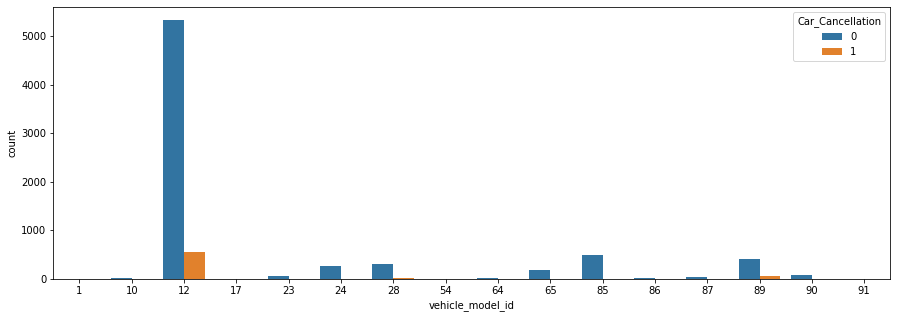

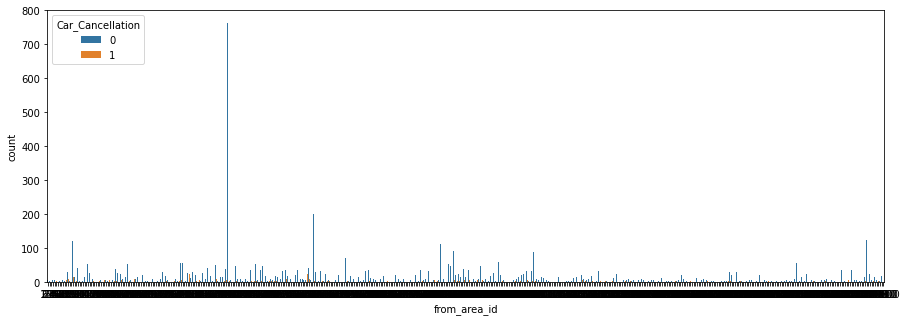

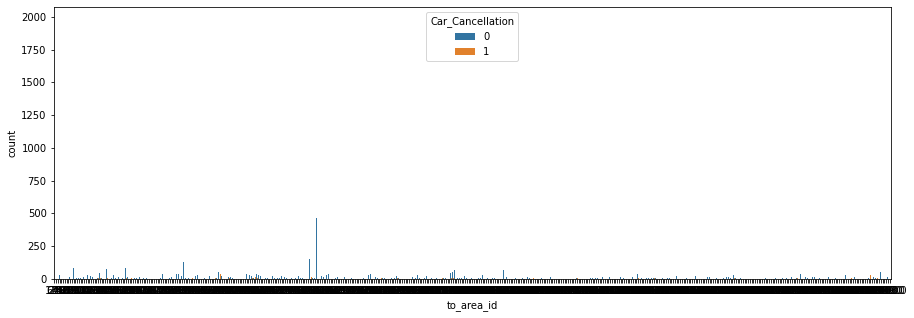

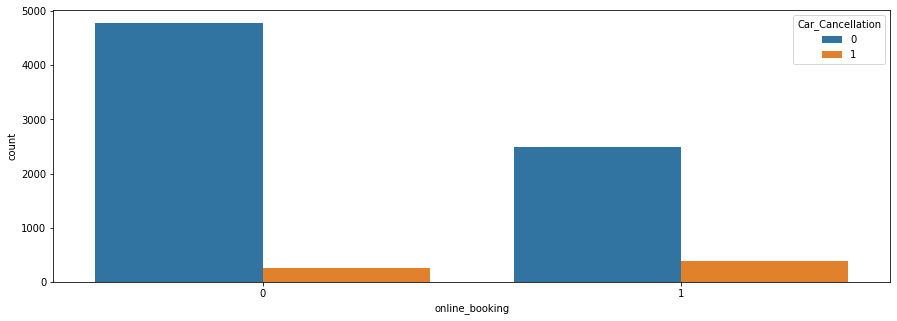

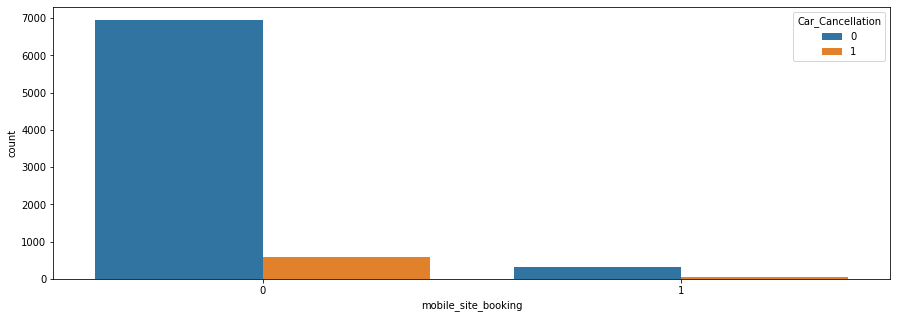

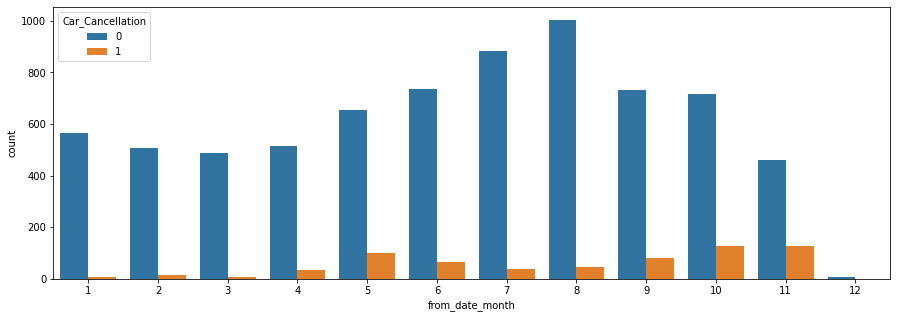

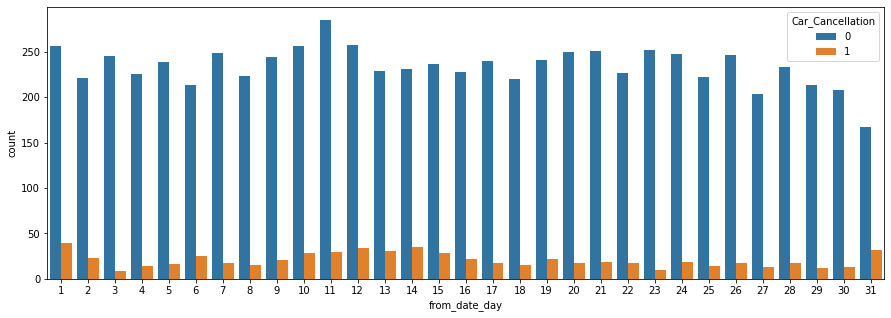

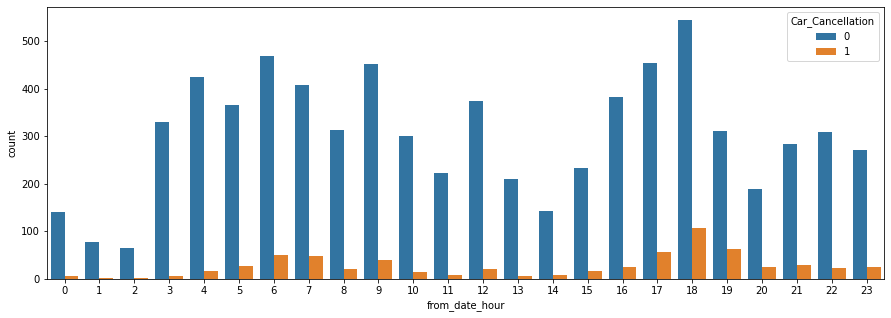

ValueError: ignored

<Figure size 1080x360 with 0 Axes>

In [385]:
# Cateforical EDA
import seaborn as sns

cat_vars = ['vehicle_model_id', 'from_area_id', 'to_area_id',
            'online_booking', 'mobile_site_booking',  
            'from_date_month', 'from_date_day', 'from_date_hour',
            'from_date_minute']
for col in cat_vars:
  plt.figure(figsize=(15,5))
  ax = sns.countplot(data = taxi_df, x = col, hue = 'Car_Cancellation')
  plt.show()

In [ ]:
print('******************')
print('Car Cancellation Balance:')
print('******************')
print(taxi_df.Car_Cancellation.value_counts(dropna=False, normalize = True))
print('\n')
for col in cat_vars:
  print('******************')
  print('{} split:'.format(col))
  print('******************')
  p1 = taxi_df[(taxi_df.Car_Cancellation == 1)].groupby(col).size().reset_index(name='Car_Cancellation_Counts')
  p2 = taxi_df.groupby(col).size().reset_index(name='Total_Scheduled_Car_Counts')
  p1['Total_Scheduled_Car_Counts'] = p2['Total_Scheduled_Car_Counts']
  p1['Percent_Cancelled'] = p1['Car_Cancellation_Counts']/p2['Total_Scheduled_Car_Counts']
  p1['Percent_Cancelled_Total'] = (p1['Car_Cancellation_Counts']/p1['Car_Cancellation_Counts'].sum()) 
  p1['Percent_Scheduled_Total'] = (p2['Total_Scheduled_Car_Counts']/p2['Total_Scheduled_Car_Counts'].sum()) 
  p1['Cancelled_Index'] = (1.0*p1['Percent_Cancelled_Total']) / (1.0*p1['Percent_Scheduled_Total']) 
  print((p1.sort_values(by=['Cancelled_Index'])))
  print('\n')

Numeric EDA

In [ ]:
taxi_df.columns

Index(['row#', 'user_id', 'vehicle_model_id', 'package_id', 'travel_type_id',
       'from_area_id', 'to_area_id', 'from_city_id', 'to_city_id', 'from_date',
       'to_date', 'online_booking', 'mobile_site_booking', 'booking_created',
       'from_lat', 'from_long', 'to_lat', 'to_long', 'Car_Cancellation',
       'dist(km)', 'from_date_year', 'from_date_month', 'from_date_day',
       'from_date_hour', 'from_date_minute', 'to_date_year', 'to_date_month',
       'to_date_day', 'to_date_hour', 'to_date_minute', 'booking_created_year',
       'booking_created_month', 'booking_created_day', 'booking_created_hour',
       'booking_created_minute', 'time_delta(secs)'],
      dtype='object')

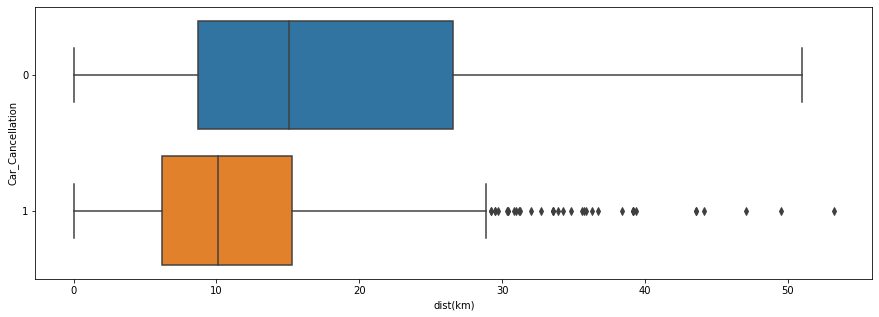

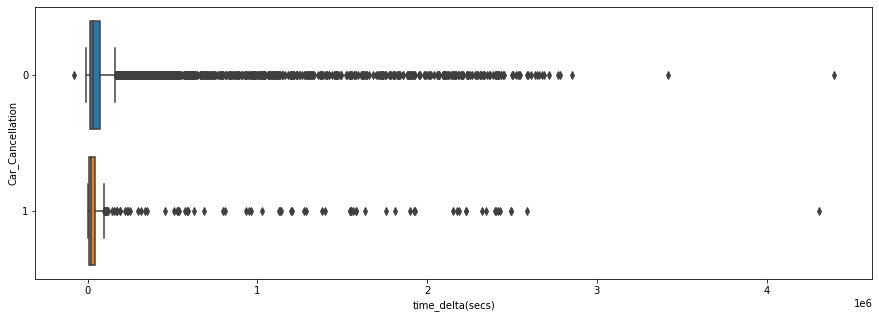

In [242]:
#Numeric EDA
num_vars = ['dist(km)', 'time_delta(secs)']

%matplotlib inline
temp_df = taxi_df
temp_df["Car_Cancellation"] = temp_df["Car_Cancellation"].astype("category")

for col in num_vars:
  plt.figure(figsize=(15,5))
  ax = sns.boxplot(data = temp_df, x = col, y = 'Car_Cancellation')
  plt.show()

Correlation Analysis

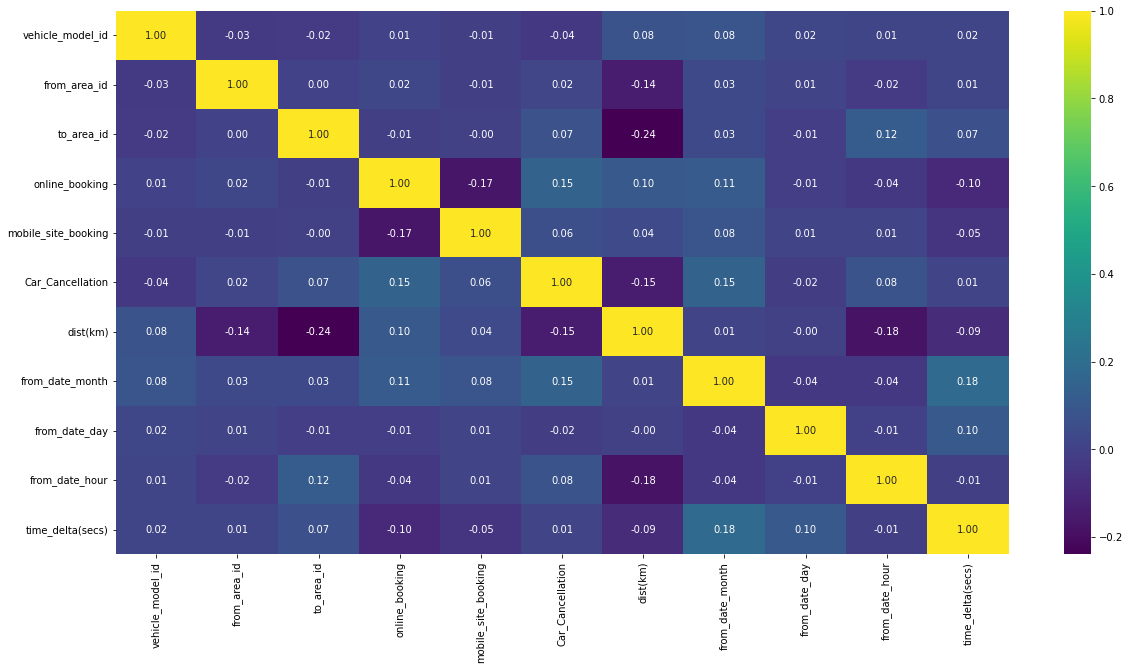

In [386]:
#correlation Analysis
plt.subplots(figsize=(20,10))
sns.heatmap(taxi_df.corr(), annot = True, fmt = ".2f", cmap = "viridis");

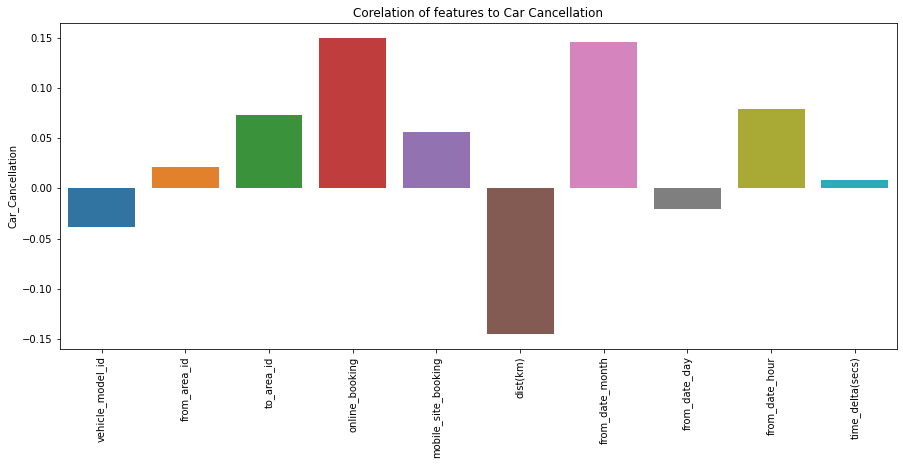

In [387]:
corr = taxi_df.corr().Car_Cancellation
plt.figure(figsize = (15,6))
sns.barplot(x = corr[:].index.drop('Car_Cancellation'), y = corr[:].drop('Car_Cancellation'))
plt.title("Corelation of features to Car Cancellation")
plt.xticks(rotation=90);

In [308]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7909 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   vehicle_model_id     7909 non-null   category
 1   from_area_id         7909 non-null   category
 2   to_area_id           7909 non-null   category
 3   online_booking       7909 non-null   int64   
 4   mobile_site_booking  7909 non-null   int64   
 5   Car_Cancellation     7909 non-null   int64   
 6   dist(km)             7909 non-null   float64 
 7   from_date_month      7909 non-null   category
 8   from_date_day        7909 non-null   category
 9   from_date_hour       7909 non-null   category
 10  time_delta(secs)     7909 non-null   int32   
dtypes: category(6), float64(1), int32(1), int64(3)
memory usage: 702.7 KB


In [413]:
# Create Instrumental / Dummy Variables

taxi_df['Car_Cancellation'] = taxi_df['Car_Cancellation'].astype("category")

# Adjust DTypes to category types
def cat_types(df, columnName):
  df[columnName] = df[columnName].astype("category")
  return columnName

# List to Apply Function to.
dummy_predictors = ['vehicle_model_id', 'from_area_id', 'to_area_id', \
                    'from_date_month', 'from_date_day', 'from_date_hour']

# List Comphension
[cat_types(taxi_df, i) for i in dummy_predictors]



temp = pd.get_dummies(taxi_df[dummy_predictors], drop_first=True)
taxi_df = pd.concat([taxi_df, temp], axis=1, join="inner")
taxi_df = taxi_df.drop(dummy_predictors, axis=1)
print(taxi_df.columns)
print(taxi_df.shape)

Index(['online_booking', 'mobile_site_booking', 'Car_Cancellation', 'dist(km)',
       'time_delta(secs)', 'vehicle_model_id_10', 'vehicle_model_id_12',
       'vehicle_model_id_17', 'vehicle_model_id_23', 'vehicle_model_id_24',
       ...
       'from_date_hour_14', 'from_date_hour_15', 'from_date_hour_16',
       'from_date_hour_17', 'from_date_hour_18', 'from_date_hour_19',
       'from_date_hour_20', 'from_date_hour_21', 'from_date_hour_22',
       'from_date_hour_23'],
      dtype='object', length=1064)
(7909, 1064)


Split Data

In [414]:
# alternative way using scikit-learn
train, temp = train_test_split(taxi_df, train_size=0.4, random_state=1)
valid, test = train_test_split(temp, train_size=0.6, random_state=1)

print('Training   : ', train.shape)
print('Validation : ', valid.shape)
print('Test : ', test.shape)

Training   :  (3163, 1064)
Validation :  (2847, 1064)
Test :  (1899, 1064)


In [415]:
# Normalize the data
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(train[['dist(km)', 'time_delta(secs)']])  # Note the use of an array of column names

# Transform the full dataset
Norm_taxi_df = pd.concat([pd.DataFrame(scaler.transform(taxi_df[['dist(km)', 'time_delta(secs)']]), 
                                    columns=['z_dist(km)', 'z_time_delta(secs)']),
                       taxi_df], axis=1).drop(['dist(km)', 'time_delta(secs)'], axis=1)



trainNorm  = Norm_taxi_df.iloc[train.index]
display(trainNorm )
validNorm = Norm_taxi_df.iloc[valid.index]
display(validNorm)
testNorm = Norm_taxi_df.iloc[test.index]
display(testNorm)

,z_dist(km),z_time_delta(secs),online_booking,mobile_site_booking,Car_Cancellation,vehicle_model_id_10,vehicle_model_id_12,vehicle_model_id_17,vehicle_model_id_23,vehicle_model_id_24,...,from_date_hour_14,from_date_hour_15,from_date_hour_16,from_date_hour_17,from_date_hour_18,from_date_hour_19,from_date_hour_20,from_date_hour_21,from_date_hour_22,from_date_hour_23
7569,-0.690650,-0.336121,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
151,-0.865283,-0.183708,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1032,-0.877844,0.376019,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2508,-0.828434,-0.364030,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1442,-0.463694,-0.365581,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,-0.104594,-0.196267,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5192,-0.751586,-0.362014,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3980,-0.253551,-0.263248,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
235,-0.005739,-0.370542,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


,z_dist(km),z_time_delta(secs),online_booking,mobile_site_booking,Car_Cancellation,vehicle_model_id_10,vehicle_model_id_12,vehicle_model_id_17,vehicle_model_id_23,vehicle_model_id_24,...,from_date_hour_14,from_date_hour_15,from_date_hour_16,from_date_hour_17,from_date_hour_18,from_date_hour_19,from_date_hour_20,from_date_hour_21,from_date_hour_22,from_date_hour_23
3351,-0.359734,-0.274412,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4825,-1.381369,-0.360464,1,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1241,0.569612,-0.203089,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5508,-0.711938,-0.137658,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4149,-0.764887,-0.357828,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4817,0.838648,-0.213322,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6220,-1.252513,-0.348060,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3178,-0.670444,-0.373023,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2440,-0.809525,-0.350541,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


,z_dist(km),z_time_delta(secs),online_booking,mobile_site_booking,Car_Cancellation,vehicle_model_id_10,vehicle_model_id_12,vehicle_model_id_17,vehicle_model_id_23,vehicle_model_id_24,...,from_date_hour_14,from_date_hour_15,from_date_hour_16,from_date_hour_17,from_date_hour_18,from_date_hour_19,from_date_hour_20,from_date_hour_21,from_date_hour_22,from_date_hour_23
718,0.696134,-0.350851,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1434,-1.366834,-0.368061,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0.366017,-0.354572,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
320,-1.393987,-0.374729,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3924,-0.722234,-0.373953,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3508,0.831836,-0.337052,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4226,0.759669,-0.294723,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4115,1.551965,-0.290382,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
882,-1.326504,-0.323097,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [416]:
# Predictor List
predictors = trainNorm.columns.values.tolist()
# Identify and remove Y from Predictors
outcome = 'Car_Cancellation'
predictors.remove(outcome)
# items to be removed from list.
omit = []

predictors = [i for i in predictors if i not in omit]

# show Predictor list
print(predictors)

['z_dist(km)', 'z_time_delta(secs)', 'online_booking', 'mobile_site_booking', 'vehicle_model_id_10', 'vehicle_model_id_12', 'vehicle_model_id_17', 'vehicle_model_id_23', 'vehicle_model_id_24', 'vehicle_model_id_28', 'vehicle_model_id_54', 'vehicle_model_id_64', 'vehicle_model_id_65', 'vehicle_model_id_85', 'vehicle_model_id_86', 'vehicle_model_id_87', 'vehicle_model_id_89', 'vehicle_model_id_90', 'vehicle_model_id_91', 'from_area_id_6.0', 'from_area_id_15.0', 'from_area_id_22.0', 'from_area_id_24.0', 'from_area_id_25.0', 'from_area_id_34.0', 'from_area_id_49.0', 'from_area_id_50.0', 'from_area_id_51.0', 'from_area_id_52.0', 'from_area_id_58.0', 'from_area_id_61.0', 'from_area_id_62.0', 'from_area_id_67.0', 'from_area_id_83.0', 'from_area_id_85.0', 'from_area_id_87.0', 'from_area_id_89.0', 'from_area_id_91.0', 'from_area_id_92.0', 'from_area_id_95.0', 'from_area_id_97.0', 'from_area_id_104.0', 'from_area_id_105.0', 'from_area_id_112.0', 'from_area_id_115.0', 'from_area_id_117.0', 'from_

In [417]:
# user grid search to find optimized tree
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 10, 15, 20, 25], 
    'min_impurity_decrease': [0, 0.00001, 0.0001, 0.001, 0.005, 0.01], 
    'min_samples_split': [5, 10, 20, 30, 40, 50], 
}

# fit the tree
smallClassTree = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1) # n_jobs=-1 will utilize all available CPUs

smallClassTree.fit(train_X, train_y)
print('Initial parameters: ', smallClassTree.best_params_)


Initial parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 10}


In [396]:
plotDecisionTree(smallClassTree, feature_names=train_X.columns)

AttributeError: ignored

Preform Exploratory Modeling

In [394]:
from sklearn.linear_model import LogisticRegressionCV

train_X = trainNorm[predictors]
train_y = trainNorm[outcome]
valid_X = validNorm[predictors]
valid_y = validNorm[outcome]

# scale = MinMaxScaler()
# train_X = scale.fit_transform(train_X)
model = LogisticRegressionCV(penalty="l2", solver='lbfgs', cv=5, max_iter=10000)
model.fit(train_X, train_y)

print('regularization', model.C_)
print('intercept ', model.intercept_[0])
df = pd.DataFrame({
    'coeff': model.coef_[0], 
    'abs_coeff': np.abs(model.coef_[0])
}, index=predictors)
print(df.sort_values(by=['abs_coeff'], ascending=False))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


regularization [0.35938137]
intercept  -4.106919749514783
                        coeff  abs_coeff
mobile_site_booking  1.599694   1.599694
from_date_month_11   1.587564   1.587564
to_area_id_393.0    -1.514541   1.514541
vehicle_model_id_89  1.505182   1.505182
online_booking       1.314790   1.314790
...                       ...        ...
from_area_id_211.0   0.000000   0.000000
from_area_id_644.0   0.000000   0.000000
to_area_id_104.0     0.000000   0.000000
to_area_id_1276.0    0.000000   0.000000
to_area_id_1173.0    0.000000   0.000000

[1063 rows x 2 columns]


---
## Question 4
Fit several predictive models of your choice. Do they provide information on how the predictor variables relate to cancellations? (15 Points)


Logistic Regression

In [458]:
# Apply logistic regression, neural networks, decision tree, and random forest classifiers to predict rideshare cancelations.

# Model: Logistic Regress to identify important variables.

from dmba.metric import AIC_score
from dmba import classificationSummary, gainsChart, liftChart


logit_rlr = LogisticRegressionCV(penalty="l2", solver='liblinear')
logit_rlr.fit(train_X, train_y)

print('regularization', logit_rlr.C_, '\n')
print('intercept ', logit_rlr.intercept_[0], '\n')

display(pd.DataFrame({'coeff': logit_rlr.coef_[0]}, index=train_X.columns).transpose())

print('\nAIC', AIC_score(valid_y, logit_rlr.predict(valid_X), df=len(train_X.columns) + 1), '\n')

# confusion matrix
classificationSummary(train_y, logit_rlr.predict(train_X))
classificationSummary(valid_y, logit_rlr.predict(valid_X))

regularization [0.35938137] 

intercept  -2.932820538456125 



,z_dist(km),z_time_delta(secs),online_booking,mobile_site_booking,vehicle_model_id_10,vehicle_model_id_12,vehicle_model_id_17,vehicle_model_id_23,vehicle_model_id_24,vehicle_model_id_28,...,from_date_hour_14,from_date_hour_15,from_date_hour_16,from_date_hour_17,from_date_hour_18,from_date_hour_19,from_date_hour_20,from_date_hour_21,from_date_hour_22,from_date_hour_23
coeff,-0.249013,0.052335,1.206741,1.51998,-0.259033,0.147889,-0.028061,-0.335766,-1.006625,-0.272675,...,-0.177339,-0.005823,-0.1324,0.144732,0.663419,0.37879,0.118588,-0.072457,-0.026504,0.234255



AIC 2932.9071838078753 

Confusion Matrix (Accuracy 0.9320)

       Prediction
Actual    0    1
     0 2886    4
     1  211   62
Confusion Matrix (Accuracy 0.9224)

       Prediction
Actual    0    1
     0 2601   30
     1  191   25


Nueral Networks

In [451]:
nn = MLPClassifier(hidden_layer_sizes=(3), activation='logistic', solver='lbfgs', random_state=1, max_iter=10000)
nn.fit(train_X, train_y)

# Network structure
print('Intercepts')
print(nn.intercepts_)
print('Weights')
print(nn.coefs_)
# Prediction
#print(pd.concat([example_df, pd.DataFrame(nn.predict_proba(X), columns=classes)], axis=1))


classificationSummary(train_y, smallClassTree.best_estimator_.predict(train_X))
classificationSummary(valid_y, smallClassTree.best_estimator_.predict(valid_X))

Intercepts
[array([-7.24548052, 26.7009716 , 30.82977151]), array([4.10928307])]
Weights
[array([[ -1.35103324,   0.54168517,   3.38244139],
       [ -2.27546407,  -0.5248606 ,  -4.63159595],
       [ -4.57267075,  -9.04788738,  -8.41030883],
       ...,
       [ -0.48997578,   0.28777641,  -2.96621768],
       [ -0.65624564,  -0.5699051 ,  -8.61807842],
       [ -0.82425085,  -4.38436572, -11.66332273]]), array([[ -4.47885737],
       [-51.33109994],
       [ -5.75379098]])]
Confusion Matrix (Accuracy 0.9260)

       Prediction
Actual    0    1
     0 2876   14
     1  220   53
Confusion Matrix (Accuracy 0.9238)

       Prediction
Actual    0    1
     0 2604   27
     1  190   26


Decision Tree

Improved parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 11}
Initial parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 11}


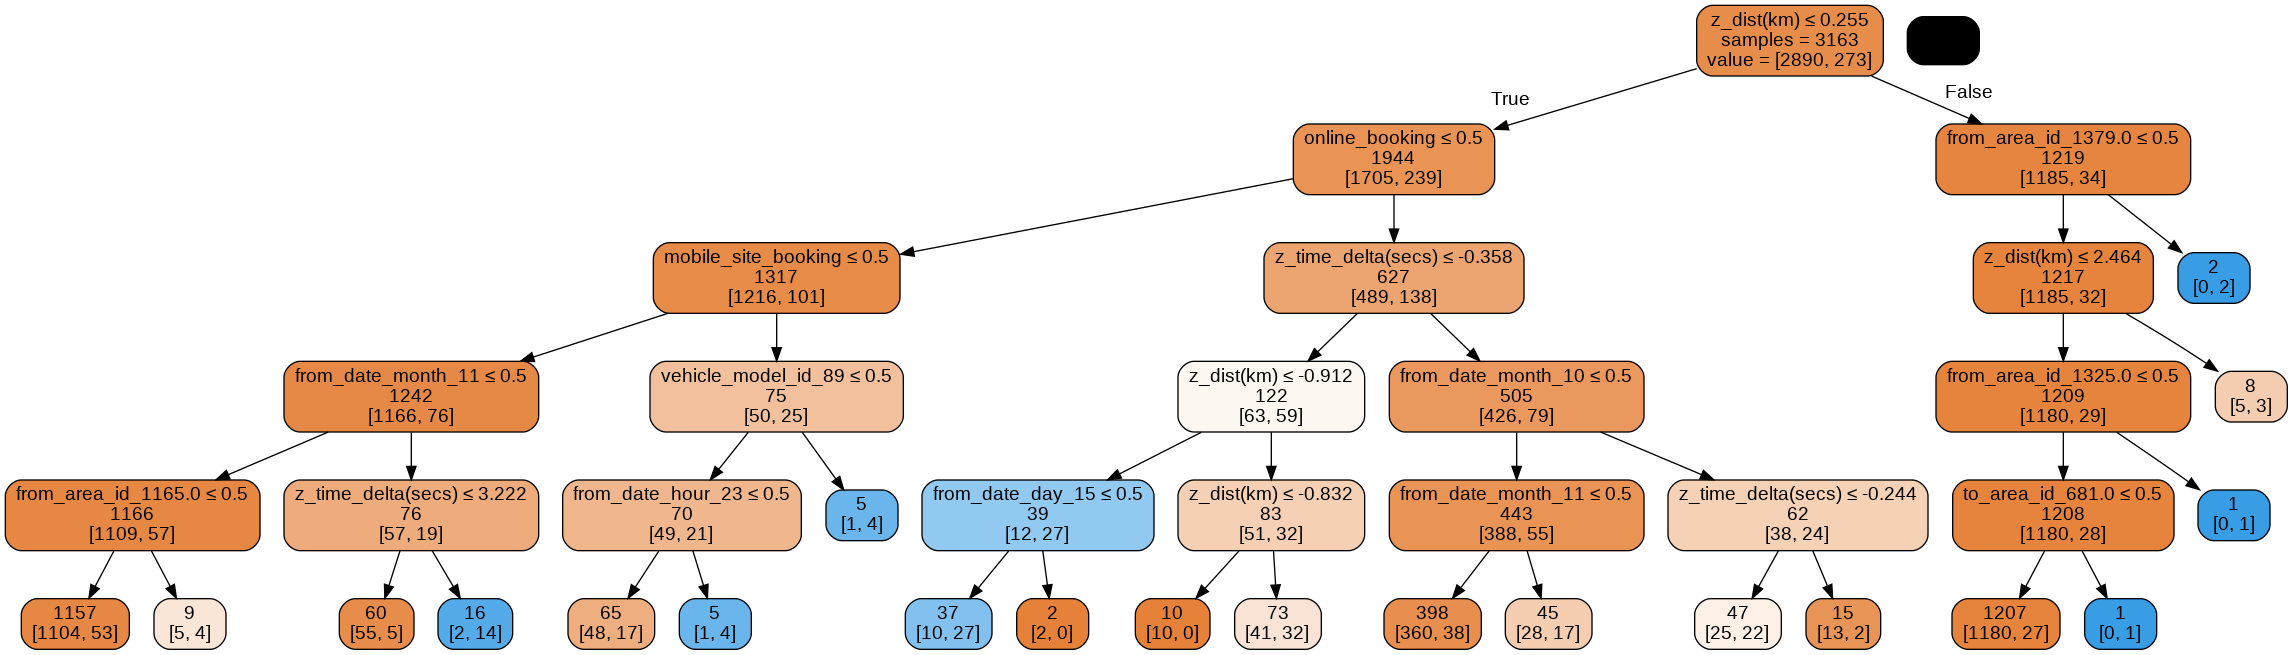

In [435]:
# use first grid search to find more optimal hyperparamters.
param_grid = {
    'max_depth': [5, 6, 7, 8, 9, 10], 
    'min_impurity_decrease': [0, 0.000001, 0.000002, 0.000003, 0.000005, 0.000006, 0.000007, 0.000008], 
    'min_samples_split': [6,7,8,9,10,11,12,13,14,15,16,18,20], 
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)

print('Initial parameters: ', gridSearch.best_params_)

plotDecisionTree(gridSearch.best_estimator_, feature_names=train_X.columns)

In [465]:
# Classification Matrix
print('Test Confusion Matrix:\n')
classificationSummary(train_y, gridSearch.best_estimator_.predict(train_X))
print('\n\nValidation Confusion Matrix:\n')
classificationSummary(valid_y, gridSearch.best_estimator_.predict(valid_X))

Test Confusion Matrix:

Confusion Matrix (Accuracy 0.9260)

       Prediction
Actual    0    1
     0 2876   14
     1  220   53


Validation Confusion Matrix:

Confusion Matrix (Accuracy 0.9238)

       Prediction
Actual    0    1
     0 2604   27
     1  190   26


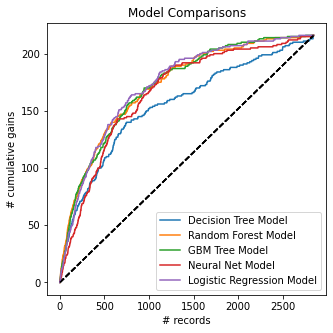

In [474]:
# Decision Trees
dec_tree_proba = gridSearch.best_estimator_.predict_proba(valid_X)
dec_tree_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in dec_tree_proba],
                            'p(1)': [p[1] for p in dec_tree_proba],
                            'predicted': gridSearch.best_estimator_.predict(valid_X),
                          })
dec_tree_result = dec_tree_result.sort_values(by=['p(1)'], ascending=False)

# Random Forest
rf_proba = rf.predict_proba(valid_X)
rf_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in rf_proba],
                            'p(1)': [p[1] for p in rf_proba],
                            'predicted': rf.predict(valid_X),
                          })
rf_result = rf_result.sort_values(by=['p(1)'], ascending=False)

# GBM Boosting Trees

gbm_tree_proba = boost.predict_proba(valid_X)
gbm_tree_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in gbm_tree_proba],
                            'p(1)': [p[1] for p in gbm_tree_proba],
                            'predicted': boost.predict(valid_X),
                          })
gbm_tree_result = gbm_tree_result.sort_values(by=['p(1)'], ascending=False)

# Neural Net

nn_proba = nn.predict_proba(valid_X)
nn_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in nn_proba],
                            'p(1)': [p[1] for p in nn_proba],
                            'predicted': nn.predict(valid_X),
                          })
nn_result = nn_result.sort_values(by=['p(1)'], ascending=False)

# Logistic Regression
logit_reg_pred = logit_rlr.predict_proba(valid_X)
logit_reg_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_pred],
                            'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted': logit_rlr.predict(valid_X)})
logit_reg_result = logit_reg_result.sort_values(by=['p(1)'], ascending=False)

# Plot
ax = gainsChart(dec_tree_result.actual, label='Decision Tree Model', color='C0', figsize=[5, 5])
ax = gainsChart(reg_tree_result.actual, label='Random Forest Model', color='C1', ax=ax)
ax = gainsChart(gbm_tree_result.actual, label='GBM Tree Model', color='C2', ax=ax)
ax = gainsChart(nn_result.actual, label='Neural Net Model', color='C3', ax=ax)
ax = gainsChart(logit_reg_result.actual, label='Logistic Regression Model', color='C4', ax=ax)
ax.legend()
ax.set_title('Model Comparisons')

plt.show()

Random Forest


                  feature  importance       std
1      z_time_delta(secs)    0.076998  0.021238
0              z_dist(km)    0.074699  0.021835
2          online_booking    0.023759  0.010486
1008   from_date_month_11    0.022305  0.010137
615      to_area_id_393.0    0.012932  0.007561
1002    from_date_month_5    0.012672  0.007307
1007   from_date_month_10    0.011772  0.006831
1057    from_date_hour_18    0.011521  0.006837
16    vehicle_model_id_89    0.011487  0.007260
3     mobile_site_booking    0.010994  0.006741


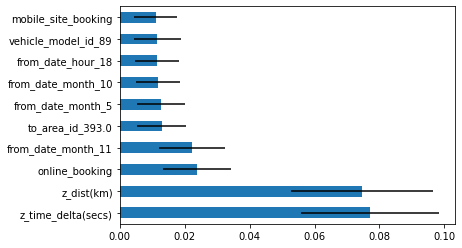

In [471]:
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)

# top 10 variable (feature) importance plot
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
df = df.nlargest(n=10, columns=['importance'])
print(df)

ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')
plt.show()


In [473]:
# Classification Matrix
print('Test Confusion Matrix:\n')
classificationSummary(train_y, rf.predict(train_X))
print('\n\nValidation Confusion Matrix:\n')
classificationSummary(valid_y, rf.predict(valid_X))

Test Confusion Matrix:

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2890    0
     1    0  273


Validation Confusion Matrix:

Confusion Matrix (Accuracy 0.9273)

       Prediction
Actual    0    1
     0 2630    1
     1  206   10


Gradient Boosting Classifier

In [441]:
# GBM Model
boost = GradientBoostingClassifier()
boost.fit(train_X, train_y)

Confusion Matrix (Accuracy 0.9252)

       Prediction
Actual    0    1
     0 2615   16
     1  197   19


In [475]:
# Classification Matrix
print('Test Confusion Matrix:\n')
classificationSummary(train_y, boost.predict(train_X))
print('\n\nValidation Confusion Matrix:\n')
classificationSummary(valid_y, boost.predict(valid_X))

Test Confusion Matrix:

Confusion Matrix (Accuracy 0.9346)

       Prediction
Actual    0    1
     0 2887    3
     1  204   69


Validation Confusion Matrix:

Confusion Matrix (Accuracy 0.9252)

       Prediction
Actual    0    1
     0 2615   16
     1  197   19


---
**Question 4 Answer:**<br>
ugh
---

---
## Question 5
Report the predictive performance of your model in terms of error rates (the confusion matrix). How well does the model perform? Can the model be used in practice? (10 Points)

In [ ]:


# confusion matrix
classificationSummary(full_result.actual, full_result.predicted, class_names=classes)

---
**Question 5 Answer:**<br>
ugh
---

---
## Question 6
Examine the predictive performance of your model in terms of ranking (lift). How well does the model perform? Can the model be used in practice? (10 Points)


In [ ]:
Score_Analysis_pred_rev = Score_Analysis_pred_rev.sort_values(by=['expected spending'], ascending=False)
# Gains and Lift Chart
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(Score_Analysis_pred_rev.Spending, ax=axes[0])
liftChart(Score_Analysis_pred_rev.Spending, title=False, ax=axes[1])
axes[0].set_title('Cumulative Gains Chart - Test Data Results')
axes[1].set_title('Cumulative Lift Chart - Test Data Results')

plt.show()

In [ ]:
logit_reg_proba = logit_red.predict_proba(valid_X)
red_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_proba],
                            'p(1)': [p[1] for p in logit_reg_proba],
                            'predicted': logit_red.predict(valid_X),
                          })
red_result = red_result.sort_values(by=['p(1)'], ascending=False)

ax = gainsChart(full_result.actual, label='Full model', color='C1', figsize=[5, 5])
ax = gainsChart(red_result.actual, label='Reduced model', color='C0', ax=ax)
ax.legend()
ax.set_title('Logistic Regression Using Fewer Predictors vs. Full Model')

plt.show()

---
**Question 6 Answer:**<br>
ugh
---

---
## Question 7
Briefly explain, in two to three paragraphs, the business objective, the data mining models used, why they were used, the model results, and your recommendations to your non-technical stakeholder team. (10 Points)


---
**Question 7 Answer:**<br>
ugh
---